In [1]:
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import locale
import math
import copy

In [138]:
import numpy as np
from scipy.optimize import brentq
from scipy.stats import norm
from fredapi import Fred
import pandas as pd

def get_zero_swap_rate_short(r, m, y=360):
    rc = []
    for i in range(len(m)):
        rc.append((y/m[i]) * np.log(1 + r[i]/(y/m[i])))
    return rc

def get_days_to_maturity(cur_date, rateMaturities):
    rateMatInDays = []
    for x in range(len(rateMaturities)):
        rateMatInDays.append((rateMaturities[x] - cur_date).days)
    return rateMatInDays

def get_disc_factor(days, rates):
    disc_factor = []
    for x in range(len(days)):
        disc_factor.append(np.exp(-1* days[x]/360.0*rates[x]))
    return disc_factor
"""
The short end of the swap curve, out to three months, is based on the
overnight, one-month, two-month and three-month deposit rates. The short-end
deposit rates are inherently zero-coupon rates and need only be 
converted to the base currency swap rate compounding frequency and day count
convention. The following equation is used to compute the continously compounded
zero swap rate for deposit rates:
    
    r_c = y/m * ln(1 + r_d/(y/m))
    where
    r_d = observed deposit rate
    m = number of days to maturity
    y = number of days in a year as according to the day count convention used.
"""

# Obtain SOFR rates
fred_api_key = '7304d4afcbd5fe7f4cb2399c18ec8267'  
fred = Fred(api_key=fred_api_key)
sofr_overnight = fred.get_series('SOFR').last('1d').values[0]/100
cur_date = datetime.date.today()

# 05 Sep 2024 data
rate = [sofr_overnight,5.118/100,4.94607/100]
rate_maturities = [cur_date + timedelta(days=1),cur_date + relativedelta(months=1),cur_date+relativedelta(months=3)]
days_to_maturity_short = get_days_to_maturity(cur_date, rate_maturities)
zero_rates_deposit_short = get_zero_swap_rate_short(rate, days_to_maturity_short)
discounts_short = get_disc_factor(days_to_maturity_short, zero_rates_deposit_short)

df_short = pd.DataFrame({'Maturities' : pd.Series(rate_maturities),'Number_of_Days' : pd.Series(days_to_maturity_short),'Original_Rates' : pd.Series(rate),'Zero_Rates' : pd.Series(zero_rates_deposit_short),'Discount_Rates' : pd.Series(discounts_short)})
df_short['Instrument'] = "Deposit"

C:\Users\justi\AppData\Local\Temp\ipykernel_16656\1322383914.py:42: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sofr_overnight = fred.get_series('SOFR').last('1d').values[0]/100


In [206]:
"""    
Futures Prices  (Assumed)
Jan 1st, 2025             96.08
Jun 1st, 2025             96.6	
Dec 1st, 2025             96.89	
Mar 1st, 2026             96.95
Sep 1st, 2026             96.98


The middle area of the swap curve up to two years is derived from
either FRA rates or interest rate futures contracts. 

Extracting forward rates from futures rates requires a convexity adjustment.
It is an adjustment for the difference in convexity characteristics of futures
contracts and forward rates.

Convexity Adjustment is based on https://timxiao1203.github.io/FuturesConvexity.pdf, to
simplify my data usage.
"""
def sofr_volatility(API_KEY):
    #fred_api_key = '7304d4afcbd5fe7f4cb2399c18ec8267'  
    fred = Fred(api_key=API_KEY)
    sofr_overnight = fred.get_series('SOFR').last('3M')
    sofr_returns = sofr_overnight.pct_change().dropna()
    sofr_volatility = sofr_returns.std()
    return sofr_volatility

def local_volatility(sigma_B, P, F):
    return sigma_B/(P * (1-F))

def bond_price_volatility(sigma_S, duration, F, P):
    return (duration) * sigma_S * P * (1 - F)

def bond_price_approximation(F, duration):
    return 1 / (1 + (duration) * (1 - F))

def convexity_adjustment(sigma, duration):
    return (sigma ** 2) / 2 * (duration)


future_prices = {
    'Date': ['2025-01-01', '2025-06-01', '2025-12-01', '2026-03-01', '2026-09-01'],
    'Price': [96.08, 96.6, 96.89, 96.95, 96.98]
}

df_medium = pd.DataFrame(future_prices)
df_medium['Date'] = pd.to_datetime(df_medium['Date'])
df_medium['Date_3_Months_After'] = df_medium['Date'] + pd.DateOffset(months=3)

# Using historical vol right now as I'm too lazy to get implied volatiltiy
sofr_30_vol = sofr_volatility('7304d4afcbd5fe7f4cb2399c18ec8267' )

df_medium['Approximated_Bond_Price'] = df_medium.apply(
    lambda row: bond_price_approximation((row['Price']) / 100, 
                                         (row['Date_3_Months_After'] - row['Date']).days / 360), 
                                         axis=1
)

df_medium['Bond_Volatility'] = df_medium.apply(
    lambda row: bond_price_volatility(sofr_30_vol, 
                                      (row['Date_3_Months_After'] - row['Date']).days / 360, 
                                      (row['Price']) / 100, 
                                      row['Approximated_Bond_Price']), 
                                      axis=1
)

df_medium['Futures_Volatility'] = df_medium.apply(
    lambda row: local_volatility(row['Bond_Volatility'],
                                 row['Approximated_Bond_Price'], 
                                 (row['Price']) / 100),
                                 axis = 1
)

df_medium['Convex_Adj'] = df_medium.apply(
    lambda row: 100 * convexity_adjustment(row['Futures_Volatility'],
                                    (row['Date_3_Months_After'] - row['Date']).days / 360),
                                    axis =1
)
df_medium['Original_Rates'] = (100 - df_medium['Price'])/100
df_medium['Adjusted_Futures_Rate'] = df_medium['Original_Rates'] + df_medium['Convex_Adj']
df_medium['Days_To_Maturity'] = get_days_to_maturity(pd.Timestamp(cur_date), df_medium['Date_3_Months_After'])

df_medium['Adjusted_Futures_Rate'] = get_zero_swap_rate_short(df_medium['Adjusted_Futures_Rate'].to_list(), df_medium['Days_To_Maturity'].to_list())
df_medium['Discount_Rates'] = 0
# df_medium['Discount_Rates'] = get_disc_factor(df_medium['Days_To_Maturity'], df_medium|['Adjusted_Futures_Rate'])
df_medium['Instrument'] = "Futures"


df_medium = df_medium[['Date', 'Days_To_Maturity', 'Instrument', 'Original_Rates', 'Adjusted_Futures_Rate', 'Discount_Rates']].rename(columns = {
    'Days_To_Maturity': 'Number_of_Days',
    'Adjusted_Futures_Rate': 'Zero_Rates',
    'Date': 'Maturities'
})



C:\Users\justi\AppData\Local\Temp\ipykernel_16656\2422003243.py:23: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sofr_overnight = fred.get_series('SOFR').last('3M')
C:\Users\justi\AppData\Local\Temp\ipykernel_16656\2422003243.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sofr_overnight = fred.get_series('SOFR').last('3M')
C:\Users\justi\AppData\Local\Temp\ipykernel_16656\2422003243.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sofr_returns = sofr_overnight.pct_change().dropna()


In [207]:
import numpy as np
def bootstrap_zero_rate(T, coupon_rate, previous_zero_rates, m=2):
    c = coupon_rate
    discounted_sum = 0
    for i in range(1, int(T * m)):
        ti = i / m  
        if ti in previous_zero_rates:
            discounted_sum += (c / m) * np.exp(-previous_zero_rates[ti] * ti)
    
    num = 1 - discounted_sum
    denom = 1 + (c / m)
    zero_rate_T = -np.log(num / denom) / T
    
    return zero_rate_T

#https://cbonds.com/indexes/?viewTree=1&index=14707,14711,14713,14715,14717,14719,14721,14723,14725,14727,14729,14731,14733,14735,14737,83883,83885
swap_par_rates = {
    'Years' : [1, 3, 5, 8, 10, 15, 20],
    'Original_Rates': ([4.3925/100, 3.6741/100, 3.5562/100, 3.565/100, 3.5965/100, 3.669/100, 3.63/100])
}
df_long = pd.DataFrame(swap_par_rates)

zero_rates = []
previous_zero_rates = {}
for idx, row in df_long.iterrows():
    T = row['Years']
    coupon_rate = row['Original_Rates']  
    zero_rate_T = bootstrap_zero_rate(T, coupon_rate, previous_zero_rates)
    zero_rates.append(zero_rate_T)
    previous_zero_rates[T] = zero_rate_T

In [208]:
df_long['Maturities'] = pd.to_datetime(datetime.datetime.today()) + pd.to_timedelta(df_long['Years'] * 365, unit='D')
df_long['Zero_Rates'] = zero_rates
df_long['Number_of_Days'] = df_long['Years'] * 365
df_long['Instrument'] = "IRS"
df_long['Discount_Rates'] = get_disc_factor(df_long['Number_of_Days'], df_long['Zero_Rates'])
df_long = df_long[df_medium.columns]
df_long = df_long.iloc[1:]

In [209]:
rates = pd.concat([df_short, df_medium, df_long])
rates['Maturities'] = pd.to_datetime(rates['Maturities'], errors='coerce')
rates['Maturities'] = rates['Maturities'].dt.date
rates = rates.set_index("Maturities")


In [210]:
rates

,Number_of_Days,Original_Rates,Zero_Rates,Discount_Rates,Instrument
Maturities,,,,,
2024-09-06,1,0.053500,0.053496,0.999851,Deposit
2024-10-05,30,0.051180,0.051071,0.995753,Deposit
2024-12-05,91,0.049461,0.049154,0.987652,Deposit
2025-01-01,208,0.039200,0.038770,0.000000,Futures
2025-06-01,361,0.034000,0.033440,0.000000,Futures
2025-12-01,542,0.031100,0.030401,0.000000,Futures
2026-03-01,634,0.030500,0.029716,0.000000,Futures
2026-09-01,817,0.030200,0.029217,0.000000,Futures
2027-09-05,1095,0.036741,0.012114,0.963823,IRS


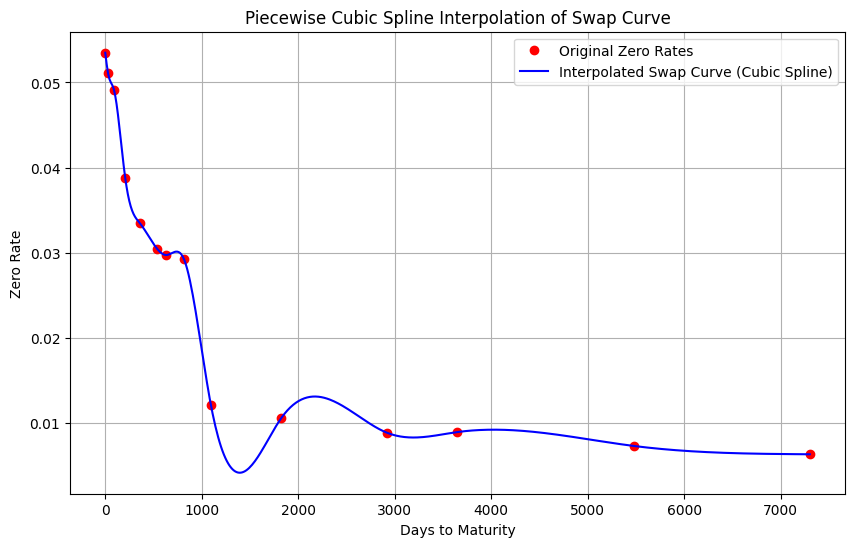

In [211]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt


zero_rates = rates['Zero_Rates'].values
maturities = rates['Number_of_Days'].values

cubic_spline = CubicSpline(maturities, zero_rates, bc_type='natural')

# Step 3: Generate a range of maturities to evaluate the spline
maturities_interpolated = np.linspace(min(maturities), max(maturities), 500)

# Step 4: Get the interpolated zero rates
interpolated_zero_rates = cubic_spline(maturities_interpolated)

# Step 5: Visualize the original data and the interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(maturities, zero_rates, 'o', label='Original Zero Rates', color='red')
plt.plot(maturities_interpolated, interpolated_zero_rates, label='Interpolated Swap Curve (Cubic Spline)', color='blue')
plt.xlabel('Days to Maturity')
plt.ylabel('Zero Rate')
plt.title('Piecewise Cubic Spline Interpolation of Swap Curve')
plt.legend()
plt.grid(True)
plt.show()

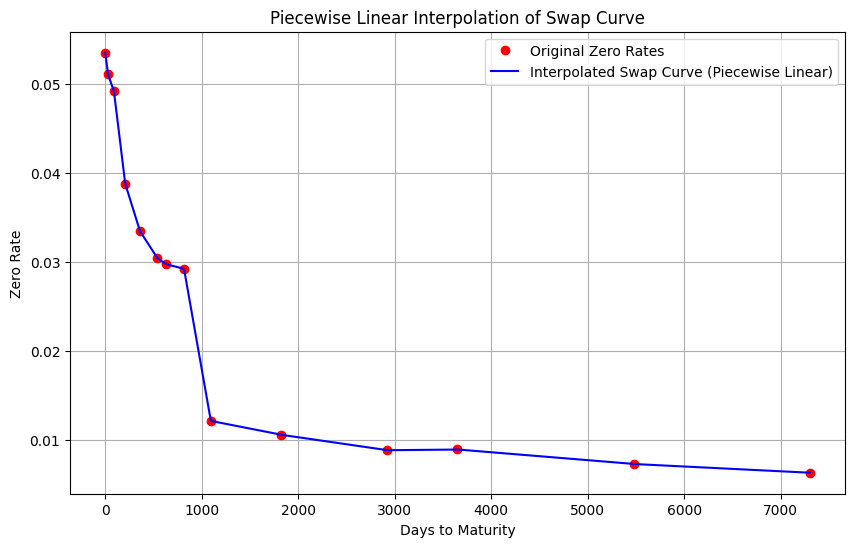

In [212]:
from scipy.interpolate import interp1d

# Assuming 'rates' DataFrame exists with 'Zero_Rates' and 'Number_of_Days' columns

zero_rates = rates['Zero_Rates'].values
maturities = rates['Number_of_Days'].values

# Step 2: Perform linear interpolation
linear_interpolation = interp1d(maturities, zero_rates, kind='linear', fill_value="extrapolate")

# Step 3: Generate a range of maturities to evaluate the interpolation
maturities_interpolated = np.linspace(min(maturities), max(maturities), 500)

# Step 4: Get the interpolated zero rates using the linear interpolation function
interpolated_zero_rates = linear_interpolation(maturities_interpolated)

# Step 5: Visualize the original data and the interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(maturities, zero_rates, 'o', label='Original Zero Rates', color='red')
plt.plot(maturities_interpolated, interpolated_zero_rates, label='Interpolated Swap Curve (Piecewise Linear)', color='blue')
plt.xlabel('Days to Maturity')
plt.ylabel('Zero Rate')
plt.title('Piecewise Linear Interpolation of Swap Curve')
plt.legend()
plt.grid(True)
plt.show()


In [223]:
final

,Maturities,Rates,Zero_Rates,Discount_Rates
0,2022-11-02,0.0305000000,0.0304987081,0.9999152850
1,2022-12-01,0.0378625000,0.0378028933,0.9968547157
2,2023-02-01,0.0414091000,0.0411915313,0.9895284874
3,2023-05-01,0.0491515000,0.0449598885,0.9776487421
4,2023-11-01,0.0486941000,0.0465418498,0.9539077938
...,...,...,...,...
115,2051-11-01,3.4370051282,0.0311822368,0.3995362818
116,2052-02-01,3.4296538462,0.0310932627,0.3974131176
117,2052-05-01,3.4223025641,0.0310097706,0.3953224483
118,2052-08-01,3.4149512821,0.0309201910,0.3932638842


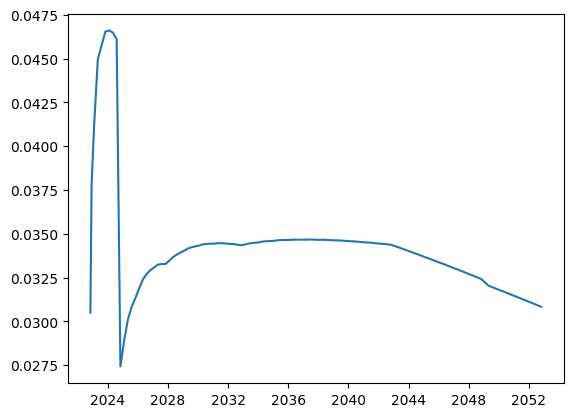

In [224]:
plt.plot(final.dropna().Maturities, final.dropna().Zero_Rates)
